# TP 3 - Reconnaissance d'espèces de fleurs par classification bayésienne


M1 CSAA

Novembre 2021

L'objectif est de réaliser un classifieur bayésien permettant de classer des images de trois espèces de fleurs. 


Télécharger tout d'abord les images de fleurs :

In [1]:
# !wget -q https://www.irit.fr/~Thomas.Pellegrini/ens/M1CSAA/Fleurs.zip
# !unzip -q Fleurs.zip
# !rm Fleurs.zip

Importer les modules nécessaires :

In [3]:
import matplotlib.image as img
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import ListedColormap

import seaborn as sns

from math import pi as PI

from sklearn.naive_bayes import GaussianNB
from sklearn import metrics


La cellule suivante affiche des images de pensées, d'oeillets et de chrysanthèmes. Vous constatez que ces images n'ont pas toutes la même taille.

./Fleurs/oe1.png
./Fleurs/oe2.png
./Fleurs/oe3.png
./Fleurs/oe4.png
./Fleurs/oe5.png
./Fleurs/oe6.png
./Fleurs/oe7.png
./Fleurs/oe8.png
./Fleurs/oe9.png
./Fleurs/oe10.png


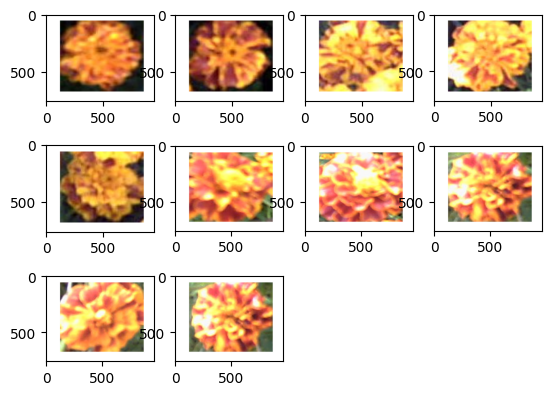

In [4]:
types_fleur = ["ch", "oe", "pe"]

def lire_image(chemin_fichier):
    return np.array(255*img.imread(chemin_fichier), dtype=int)


def affichage_images(type_fleur='ch', n_fleurs=10):
    """Affichage d'images de fleurs

    Arguments:
        type_fleur='ch', 'oe', 'pe'
        n_fleurs: nombre de fleurs à afficher dans la figure
    """

    for i in range(n_fleurs):
        path = "./Fleurs/"
        name = path + type_fleur + str(i + 1) + ".png"
        print(name)
        image = lire_image(name)
        plt.figure(1)
        plt.subplot(3, 4, i + 1)
        plt.imshow(image)

    plt.show()

affichage_images(type_fleur='oe', n_fleurs=10)

## Prétraitement : calcul de la couleur moyenne d'une image}

Dans un premier temps, vous allez classer les images selon la couleur moyenne de chaque espèce de fleurs. En chaque pixel de chaque image, les trois niveaux de couleur $(R,V,B) \in [0,255]^3$ sont d'abord transformés en ***niveaux de couleur normalisés*** $(r,v,b)$, qui sont définis de la manière suivante :

\begin{equation*} 
	(r,v,b) = \frac{1}{\max\{1,R+V+B\}}\,(R,V,B)
\end{equation*}

Le principal intérêt des niveaux de couleur normalisés est que deux valeurs parmi $(r,v,b)$ permettent de déduire la troisième, puisque $r+v+b=1$, sauf dans le cas exceptionnel où $(r,v,b)=(0,0,0)$. Une image est donc caractérisée par les moyennes $(\bar{r},\bar{v},\bar{b})$, ou plus simplement par $(\bar{r},\bar{v})$, puisque $\bar{r}+\bar{v}+\bar{b}=1$, c'est-à-dire par un vecteur $\textbf{x}=[\bar{r},\bar{v}]\in\mathbb{R}^2$ qu'on appelle sa ***couleur moyenne***. Compte tenu des différences de couleurs moyennes entre les trois espèces de fleurs, on postule que ce vecteur suffira à les distinguer.

Écrire dans la cellule suivante la fonction `Pretraitement`, qui calcule la couleur moyenne d'une image. 

La fonction `Pretraitement` est censée normaliser les couleurs d'une image et calculer les couleurs moyennes $[\bar{r},\bar{v}]$ dans $\mathbb{R}^2$ de l'image. 

In [5]:
def Pretraitement(image: np.array):
    array_moyen = jnp.divide(1, jnp.maximum(1, jnp.sum(image, axis=2)))
    new_image = jnp.multiply(image, array_moyen[:, :, None])
    return jnp.mean(new_image, axis=(0,1))[0:2]

In [6]:
test = Pretraitement(lire_image("./Fleurs/oe2.png"))

In [7]:
test

Array([0.45719507, 0.30380857], dtype=float32)

In [8]:
test.shape

(2,)

Compléter la fonction `calcule_moy_toutes_images` qui retourne un dictionnaire dont les clés sont les trois espèces de fleurs et les valeurs associées une matrice numpy contenant les couleurs moyennes $[\bar{r},\bar{v}]$ des `n_fleurs` de l'espèce clé.  


In [9]:

def calcule_moy_toutes_images(n_fleurs=10):

    types_fleur = ["ch", "oe", "pe"]
    feat_dic = {"ch":[], "oe": [], "pe": []}
    for i in range(n_fleurs):
        for type_fleur in types_fleur:
            path = "./Fleurs/"
            name = path + type_fleur + str(i + 1) + ".png"
            image = lire_image(name)
            feat_dic[type_fleur].append(Pretraitement(image))
    for type_fleur in types_fleur:
        feat_dic[type_fleur] = jnp.array(feat_dic[type_fleur])
    return feat_dic


In [10]:
test_dict = calcule_moy_toutes_images(n_fleurs=10)

In [11]:
len(test_dict['ch'])

10


Affichez les couleurs moyennes de l'ensemble des images de fleurs sous la forme de trois nuages de points de $\mathbb{R}^2$.



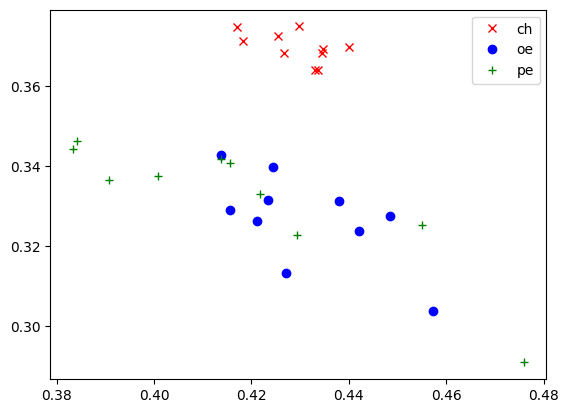

In [12]:
    feat_dic = calcule_moy_toutes_images()
    plt.figure()
    plt.plot(feat_dic["ch"][:, 0], feat_dic["ch"][:, 1], "xr", label='ch')
    plt.plot(feat_dic["oe"][:, 0], feat_dic["oe"][:, 1], "ob", label='oe')
    plt.plot(feat_dic["pe"][:, 0], feat_dic["pe"][:, 1], "+g", label='pe')
    plt.legend()
    plt.show()



La couleur moyenne vous semble-t-elle une caractéristique suffisamment discriminante de ces trois espèces de fleurs ?

# Classification avec GaussianNB de sklearn : le classifieur bayésien naïf gaussien 

In [13]:
def split_data(feat_dic):
    
    nb_train_fleur = 6
    nb_test_fleur = 10 - nb_train_fleur
    types_fleur = ["ch", "oe", "pe"]
    x_train, y_train, x_test, y_test = [], [], [], []
    for t in types_fleur:
        x_train.extend(feat_dic[t][0:nb_train_fleur])
        y_train.extend([types_fleur.index(t)]*nb_train_fleur)
        x_test.extend(feat_dic[t][nb_train_fleur:])
        y_test.extend([types_fleur.index(t)]*nb_test_fleur)
    return np.asarray(x_train), np.asarray(y_train), np.asarray(x_test), np.asarray(y_test)

In [14]:
x_train, y_train, x_test, y_test = split_data(feat_dic)

In [15]:
x_train.shape, y_train, x_test.shape, y_test

((18, 2),
 array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]),
 (12, 2),
 array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2]))

In [16]:
x_train

array([[0.43470365, 0.36908108],
       [0.4267814 , 0.36814028],
       [0.4171077 , 0.37475982],
       [0.43368056, 0.3639194 ],
       [0.43993914, 0.36978677],
       [0.41835293, 0.37121204],
       [0.44841707, 0.32753962],
       [0.45719507, 0.30380857],
       [0.42444864, 0.33973688],
       [0.41375166, 0.3427467 ],
       [0.4379411 , 0.33117533],
       [0.44207054, 0.32363313],
       [0.42180905, 0.3330536 ],
       [0.47592843, 0.29084858],
       [0.41554558, 0.34060624],
       [0.3907277 , 0.33634964],
       [0.4137313 , 0.34172228],
       [0.38338345, 0.3442947 ]], dtype=float32)

Instancier un classifieur GaussianNB et l'entraîner sur le sous-ensemble de train. Calculer sa précision sur les sous-ensembles de train et de test. 

In [17]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

model = GaussianNB()
model.fit(x_train, y_train)

GaussianNB()

In [18]:
from sklearn.metrics import f1_score

In [19]:
preds = model.predict(x_test)

In [20]:
f1_score(y_test, preds, average='macro')

0.746031746031746

Cette cellule affiche la matrice de confusion sur le sous-ensemble de test.

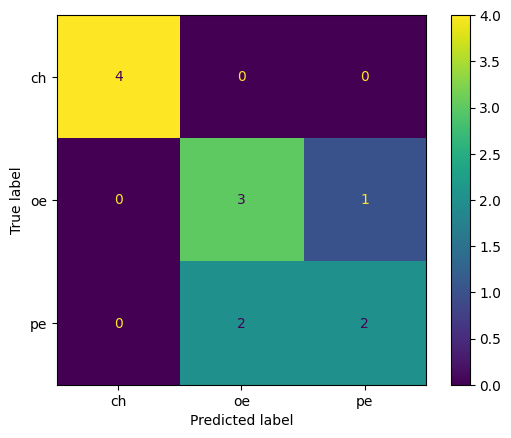

In [21]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, preds), display_labels=types_fleur).plot()

Commenter cette matrice de confusion.

À l'aide de la méthode `predict`, déterminer la prédiction que fait le classifieur pour le dernier exemple de x_test.

In [22]:
model.predict(x_test[-1].reshape(1, -1))

array([1])

À l'aide de la méthode `predict_proba`, calculer les probabilités des trois classes pour le dernier exemple de x_test.

In [23]:
model.predict_proba(x_test[-1].reshape(1, -1))

array([[1.64612778e-44, 7.40271861e-01, 2.59728139e-01]])

Cette cellule trace les régions de décision du classifieur. 

(0.27084858298301695, 0.39084858298301706)

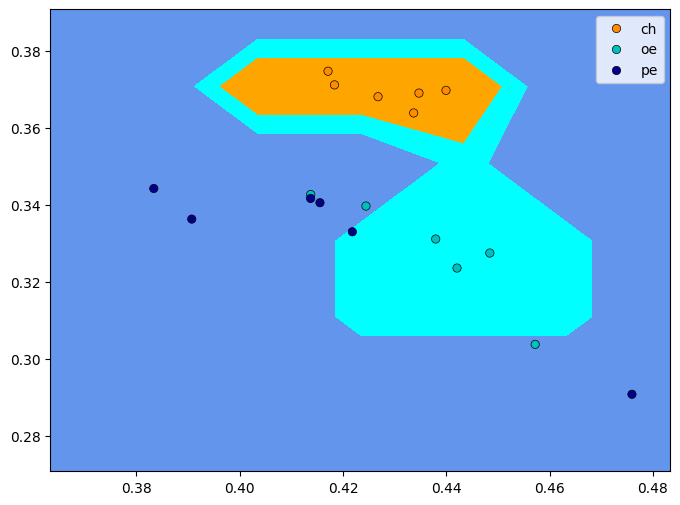

In [24]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max]

h = 0.02  # step size in the mesh
x_min, x_max = x_train[:, 0].min() - 0.02, x_train[:, 0].max() + 0.02
y_min, y_max = x_train[:, 1].min() - 0.02, x_train[:, 1].max() + 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(8, 6))
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "c", "darkblue"]

plt.contourf(xx, yy, Z, cmap=cmap_light)

target_names = [types_fleur[y_train[i]] for i in range(y_train.shape[0]) ]
sns.scatterplot(
    x=x_train[:, 0],
    y=x_train[:, 1],
    hue=target_names,
    palette=cmap_bold,
    alpha=1.0,
    edgecolor="black",
)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())


Enfin, il est possible de récupérer les moyennes et les variances des gaussiennes du classifieur pour chacune des trois classes :

In [25]:
print("Moyennes des Gaussiennes : \n", model.theta_)
print("Variances des Gaussiennes : \n", model.var_)

Moyennes des Gaussiennes : 
 [[0.42842755 0.36948323]
 [0.43730399 0.32810673]
 [0.41685426 0.33114582]]
Variances des Gaussiennes : 
 [[7.19745081e-05 1.06407839e-05]
 [2.10375657e-04 1.61623466e-04]
 [8.88110779e-04 3.38140090e-04]]


On voit que pour chaque classe, il y a deux variances associées aux deux attributs $\bar{r},\bar{v}$. Si nous utilisions une classifieur Gaussien sans faire l'hypothèse "naïve", nous aurions une matrice $2 \times 2$ pour caractériser la variance. 

Comme vu en cours, le classifieur naïf fait l'hypothèse qu'il n'y a pas d'interaction entre les attributs. Les attributs sont supposés indépendants entre eux.

## Votre classifieur Gaussien

Dans cette partie du TP, vous allez implémenter votre propre classifieur gaussien, sans faire l'hypothèse naïve.

Les trois nuages de points précédents vont donc être modélisés par des lois normales bidimensionnelles. Il est rappelé que la densité de probabilité d'une loi normale s'écrit, en dimension $d$ :

\begin{equation}
	p(\textbf{x})=\cfrac{1}{(2\pi)^{d/2}\,(\det\Sigma)^{1/2}} \,\exp\left\{-\cfrac{1}{2}\,(\textbf{x}-\mu)\Sigma^{-1}(\textbf{x}-\mu)^\top\right\}
\end{equation}

où :

- $\mu$ désigne l'espérance (la moyenne) des vecteurs $\textbf{x}\in\mathbb{R}^d$ : $\mu = E[\textbf{x}]= \int\textbf{x}\,p(\textbf{x})\,d \textbf{x}$.

- $\Sigma$ désigne la matrice de variance/covariance : $\Sigma = E[(\textbf{x}-\mu)^T(\textbf{x}-\mu)]$. 

Dans le cadre bayésien, la vraisemblance de la classe $\omega_i$, qui est caractérisée par la moyenne $\mu_i$ et la matrice de variance/covariance $\Sigma_i$, peut être modélisée par une loi normale analogue à \eqref{eq:loi_normale} :

\begin{equation*}
	p(\textbf{x}|\omega_i) = \frac{1}{(2\pi)^{d/2}\,(\det\Sigma_i)^{1/2}} \,\exp\left\{-\frac{1}{2}\,(\textbf{x}-\mu_i){\Sigma_i}^{-1} (\textbf{x}-\mu_i)^\top\right\} \, \text{, } \quad i\in[1,3]
\end{equation*}

Il faut donc estimer les paramètres $\mu_i$ et $\Sigma_i$ des trois classes correspondant aux trois espèces de fleurs. 


Compléter la méthode `fit()` de l'objet `GaussianBayes` :


In [26]:
class GaussianBayes(object):
    """ Classification bayesienne Gaussienne
    """
    def __init__(self, priors:np.ndarray=None, nb_train_examples=6) -> None:
        self.priors = priors    # a priori probabilities of classes
                                # (n_classes,)

        self.mu = None          #  mean of each feature per class
                                # (n_classes, n_features)
        self.sigma = None       # covariance of each feature per class
                                # (n_classes, n_features, n_features)

        self.nb_train_examples = nb_train_examples


    def fit(self, X:np.ndarray, y:np.ndarray, ) -> None:
        """Learning : estime self.mu et self.sigma
        
        X : shape (n_data, n_features)
        y : shape (n_data)
        """
        num_classes = len(np.unique(y))
        classes = np.unique(y)

        n_features = X.shape[1]

        self.mu = np.zeros((num_classes, n_features))
        self.sigma = np.zeros((num_classes, n_features, n_features))

        for idx, c in enumerate(np.unique(y)):
            self.mu[idx, :] = np.mean(X[y==c], axis=0)
            self.sigma[idx, :, :] = np.cov(X[y==c].T)

        if self.priors is None:
            self.priors = np.array([np.sum(y == cls) for cls in classes]) / len(y)


    def predict(self, X:np.ndarray) -> np.ndarray:
        """retourne un vecteur de prédictions sur X contenant les indices des classes prédites

        X shape = [n_samples, n_features]
        maximum log-likelihood
        """
        n_samples, n_features = X.shape
        n_classes = len(self.priors)
        log_likelihood = np.zeros((n_samples, n_classes))

        for idx in range(n_classes):
            # Inverse and determinant of the covariance matrix
            sigma_inv = np.linalg.inv(self.sigma[idx])
            sigma_det = np.linalg.det(self.sigma[idx])

            # Compute the log-likelihood for each sample
            for i in range(n_samples):
                diff = X[i] - self.mu[idx]
                log_likelihood[i, idx] = -0.5 * np.log(sigma_det) - 0.5 * np.dot(diff.T, np.dot(sigma_inv, diff)) - 0.5 * n_features * np.log(2 * np.pi)

            # Add the log of the prior probability
            log_likelihood[:, idx] += np.log(self.priors[idx])

        # Choose the class with the highest log-likelihood
        predictions = np.argmax(log_likelihood, axis=1)
        return predictions 


Instancier le classifieur et l'entraîner sur le sous-ensemble `x_train`: 

In [27]:
clf = GaussianBayes()

In [28]:
clf.fit(x_train, y_train)

In [29]:
clf.mu

array([[0.42842755, 0.36948323],
       [0.43730399, 0.32810673],
       [0.41685426, 0.33114582]])

In [30]:
clf.sigma

array([[[ 8.63694124e-05, -2.06386259e-05],
        [-2.06386259e-05,  1.27689405e-05]],

       [[ 2.52450770e-04, -2.00660552e-04],
        [-2.00660552e-04,  1.93948153e-04]],

       [[ 1.06573292e-03, -5.98508970e-04],
        [-5.98508970e-04,  4.05768132e-04]]])

Compléter maintenant la méthode `predict` en n'utilisant pas, dans un premier temps les probabilités a priori.


C'est-à-dire que votre classifieur fait des prédictions selon la règle du maximum de vraisemblance :

consiste à affecter à $\textbf{x}$ la classe $\omega_i$ qui maximise la vraisemblance $p(\textbf{x}|\omega_i)$. 


Faire des prédictions sur le sous-ensemble de train et calculer la précision obtenue

In [31]:
pred = clf.predict(x_train)

precision = np.mean(pred == y_train)
print("précision train = %.2f%%"%(precision*100))

pred

précision train = 88.89%


array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2])

Même question sur le sous-ensemble de test :

In [32]:
pred = clf.predict(x_test)
precision = np.mean(pred == y_test)
print("précision test = %.2f%%"%(precision*100))

pred

précision test = 58.33%


array([0, 0, 0, 0, 2, 2, 2, 2, 1, 2, 2, 2])

Ce classifieur est-il meilleur ou moins bon que le classifieur naïf ? À votre avis pourquoi ?

### C'est beaucoup moins bon. Le classifieur naïf a atteint une précision de 75% au lieu de 58.33% pour ce classifieur.

Rajoutons maintenant la possibilité d'utiliser les probabilités a priori des classes. Pour cela, modifier la méthode predict.

Pour rappel du cours, la règle de Bayes donne l'expression suivante de la ***probabilité a posteriori*** $p(\omega_i|\textbf{x})$, c'est-à-dire de la probabilité pour que la classe $\omega_i$ contienne $\textbf{x}$ :

\begin{equation}
	p(\omega_i|\textbf{x}) = \frac{p(\textbf{x}|\omega_i)\,p(\omega_i)}{p(\textbf{x})}
\end{equation}

Il semble naturel d'affecter à $\textbf{x}$ la classe $\omega_i$ qui maximise $p(\omega_i|\textbf{x})$. Une telle classification est dite par ***maximum a posteriori*** (MAP). 

Sachant que le dénominateur $p(\textbf{x})$ est indépendant de $\omega_i$, il n'est pas nécessaire de le connaître pour trouver le maximum des $p(\omega_i|\textbf{x})$. En revanche, il est nécessaire de connaître la ***probabilité a priori*** $p(\omega_i)$ de chaque classe $\omega_i$, faute de quoi on fait généralement l'hypothèse que les classes sont équiprobables (l'estimateur par maximum a posteriori revient alors à un estimateur par maximum de vraisemblance).


En jouant sur les probabilités a priori des trois classes, vous essaierez de maximiser le pourcentage d'images correctement classées 

## Amélioration du classifieur

Même en jouant sur les probabilités a priori, le classifieur obtenu reste décevant. Or, l'observation attentive des images de pensées et d'oeillets, dont les couleurs moyennes sont similaires, montre que ces deux espèces de fleurs ne sont pas structurées de la même façon : les pensées sont plus sombres au centre, c'est-à-dire au niveau du pistil. Cela suggère de ne pas seulement calculer la couleur moyenne des images, mais de scinder chaque image en deux parties complémentaires : le centre $C$ (notion à préciser) et le pourtour $P$ (complémentaire de $C$).

Écrire une nouvelle classe `GaussianBayesBetter` reprenant le principe du classifieur MAP précédent, mais utilisant trois caractéristiques pour décrire une image, à savoir le couple de valeurs $(\bar{r},\bar{v})$ calculées sur le pourtour $P$ et la valeur $\bar{r}$ calculée sur le centre $C$.

In [33]:
def Pretraitement2(image: np.array):
    """
    Returns: Tuple(Center Red, Surrounding Red + Green)
    """
    h, w, c = image.shape
    center_h, center_w = h//2, w//2
    extent_h, extent_w = h//5, w//5
    center_image = image[center_h-extent_h:center_h+extent_h, center_w-extent_w:center_w+extent_w, :]


    array_moyen = jnp.divide(1, jnp.maximum(1, jnp.sum(center_image, axis=2)))
    center_normed = jnp.multiply(center_image, array_moyen[:, :, None])

    surrounding = image.copy()
    surrounding[center_h-extent_h:center_h+extent_h, center_w-extent_w:center_w+extent_w, :] = 0
    array_moyen_surr = jnp.divide(1, jnp.maximum(1, jnp.sum(surrounding, axis=2)))
    surrounding_normed = jnp.multiply(surrounding, array_moyen_surr[:, :, None])
    return jnp.mean(center_normed, axis=(0,1))[0:1], jnp.mean(surrounding_normed, axis=(0,1))[0:2]

In [37]:
test2 = Pretraitement2(lire_image("./Fleurs/oe2.png"))

In [38]:
test2

(Array([0.56081283], dtype=float32),
 Array([0.367866 , 0.2548967], dtype=float32))

In [40]:
os.listdir("./Fleurs/")

['ch3.png',
 'oe9.png',
 'oe10.png',
 'oe8.png',
 'ch2.png',
 'ch1.png',
 'ch5.png',
 'ch4.png',
 'ch6.png',
 'pe8.png',
 'pe9.png',
 'ch7.png',
 'ch10.png',
 'pe4.png',
 'pe5.png',
 'pe10.png',
 'oe1.png',
 'ch9.png',
 'oe3.png',
 'pe7.png',
 'pe6.png',
 'oe2.png',
 'ch8.png',
 'oe6.png',
 'pe2.png',
 'pe3.png',
 'oe7.png',
 'oe5.png',
 'pe1.png',
 'oe4.png']

In [39]:
import os
images = [lire_image(image) for image in os.listdir("./Fleurs/")]

FileNotFoundError: [Errno 2] No such file or directory: 'ch3.png'

In [35]:
def calcule_moy_toutes_images2(n_fleurs=10):

    types_fleur = ["ch", "oe", "pe"]
    feat_dic = {"ch":[], "oe": [], "pe": []}
    for i in range(n_fleurs):
        for type_fleur in types_fleur:
            path = "./Fleurs/"
            name = path + type_fleur + str(i + 1) + ".png"
            image = lire_image(name)
            feat_dic[type_fleur].append(Pretraitement2(image))
    for type_fleur in types_fleur:
        feat_dic[type_fleur] = jnp.array(feat_dic[type_fleur])
    return feat_dic


In [36]:
feat_dic2 = calcule_moy_toutes_images2()

ValueError: All input arrays must have the same shape.